In [88]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
#for filter
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;
from scipy.signal import find_peaks
import scipy
from scipy import signal
import librosa
import librosa.display
import os
import math

In [89]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes);

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

In [3]:
import scipy as sp
from scipy import signal

def emd(x, nIMF = 3, stoplim = .001):
    """Perform empirical mode decomposition to extract 'niMF' components out of the signal 'x'."""
    
    r = x
    t = np.arange(len(r))
    imfs = np.zeros(nIMF,dtype=object)
    for i in range(nIMF):
        r_t = r
        is_imf = False
        
        while is_imf == False:
            # Identify peaks and troughs
            pks = sp.signal.argrelmax(r_t)[0]
            trs = sp.signal.argrelmin(r_t)[0]
            
            # Interpolate extrema
            pks_r = r_t[pks]
            fip = sp.interpolate.InterpolatedUnivariateSpline(pks,pks_r,k=3)
            pks_t = fip(t)
            
            trs_r = r_t[trs]
            fitr = sp.interpolate.InterpolatedUnivariateSpline(trs,trs_r,k=3)
            trs_t = fitr(t)
            
            # Calculate mean
            mean_t = (pks_t + trs_t) / 2
            mean_t = _emd_complim(mean_t, pks, trs)
            
            # Assess if this is an IMF (only look in time between peaks and troughs)
            sdk = _emd_comperror(r_t, mean_t, pks, trs)
            
            # if not imf, update r_t and is_imf
            if sdk < stoplim:
                is_imf = True
            else:
                r_t = r_t - mean_t
                
        
        imfs[i] = r_t
        r = r - imfs[i] 
        
    return imfs


def _emd_comperror(h, mean, pks, trs):
    """Calculate the normalized error of the current component"""
    samp_start = np.max((np.min(pks),np.min(trs)))
    samp_end = np.min((np.max(pks),np.max(trs))) + 1
    return np.sum(np.abs(mean[samp_start:samp_end]**2)) / np.sum(np.abs(h[samp_start:samp_end]**2))


def _emd_complim(mean_t, pks, trs):
    samp_start = np.max((np.min(pks),np.min(trs)))
    samp_end = np.min((np.max(pks),np.max(trs))) + 1
    mean_t[:samp_start] = mean_t[samp_start]
    mean_t[samp_end:] = mean_t[samp_end]
    return mean_t

In [5]:
#get the chestband signal
#df = pd.read_csv("SpiroMask-July2021/chestBandData/Yash_Tidal_N95_GT_3_still.csv", names=['X','Y','Z'])
#df = pd.read_csv('SpiroMask-July2021/chestBandData/sensorlog_20210721_155550_Nipun.csv')
#df = df[0:2000]
#sr=100
#df['Time'] = [s/sr for s in range(0,df.shape[0])]

In [8]:
mypath="SpiroMask-July2021/SmartMaskData/Tidal/N95/"
(_, _, filenames) = next(os.walk(mypath))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


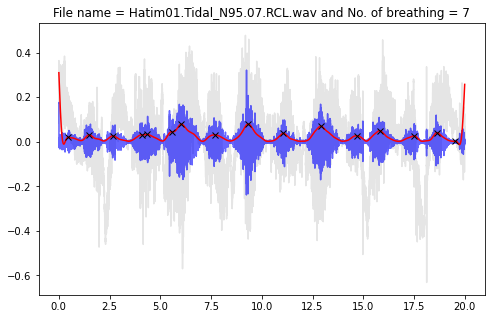

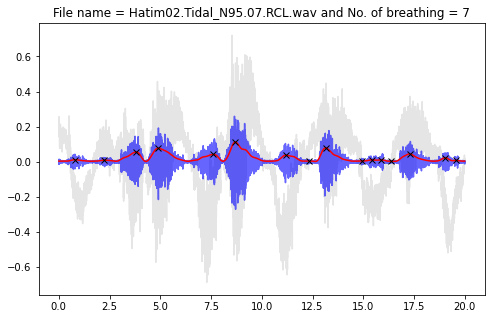

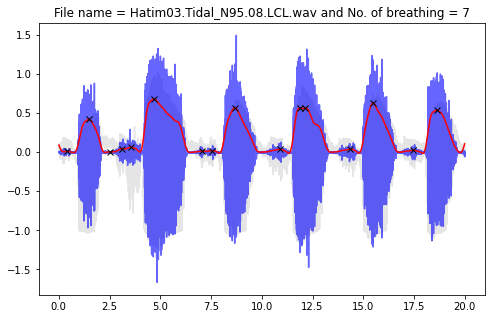

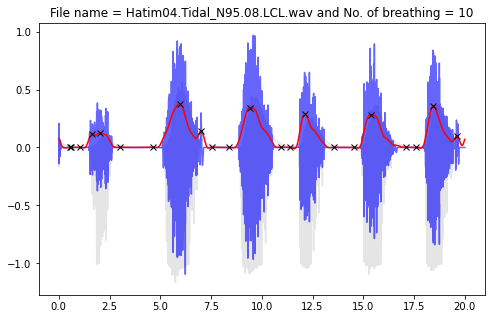

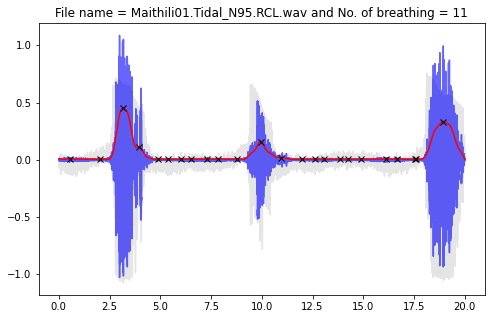

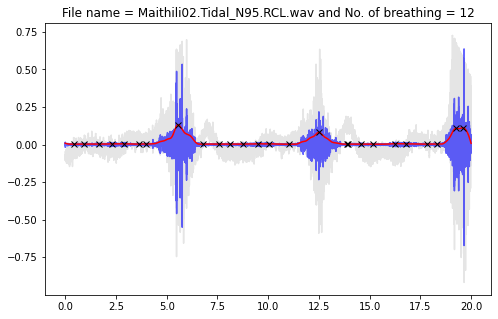

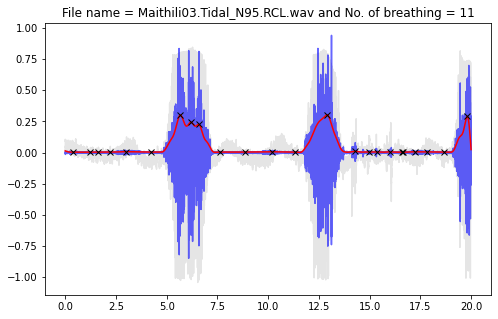

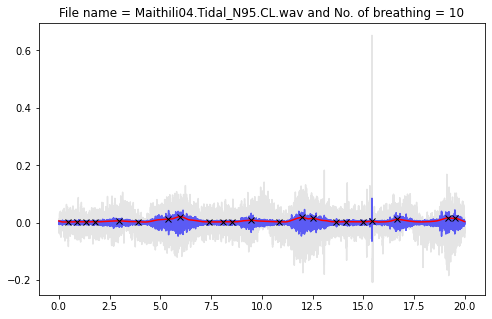

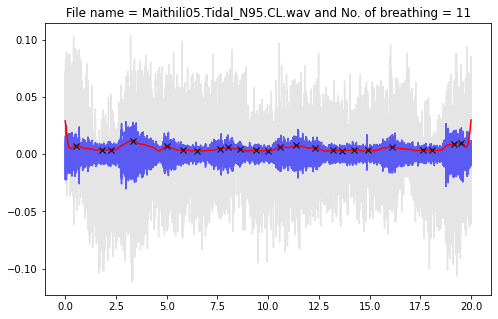

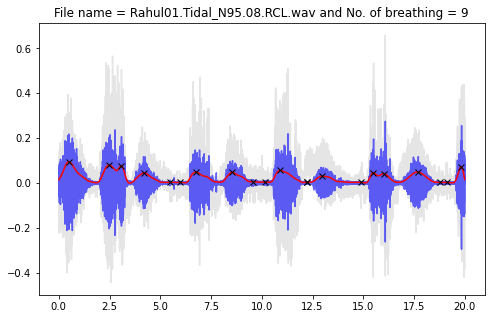

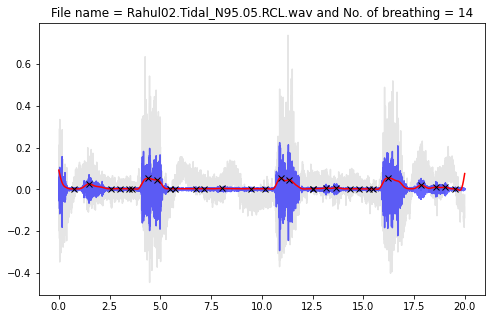

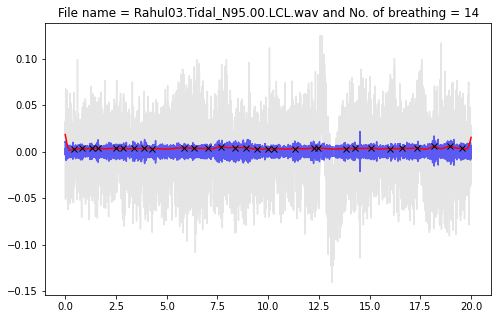

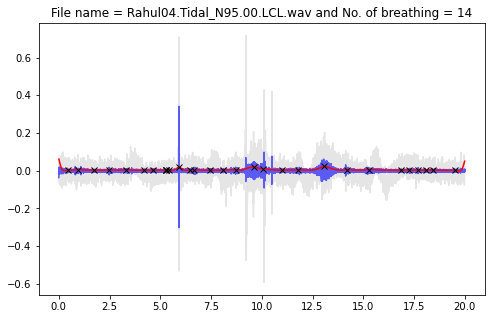

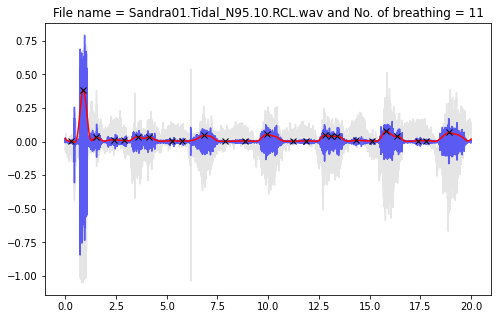

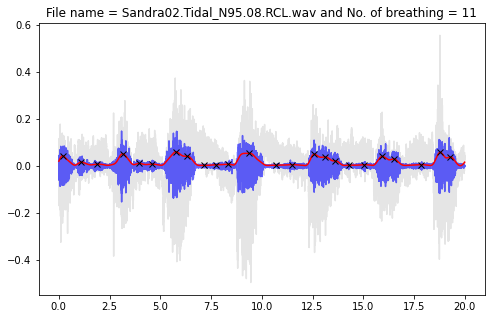

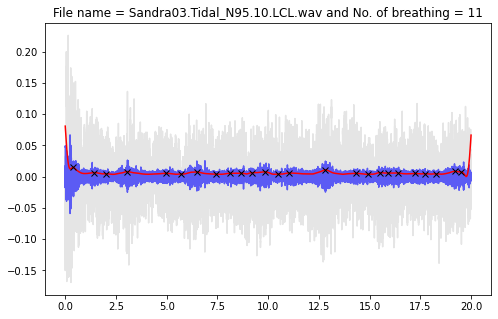

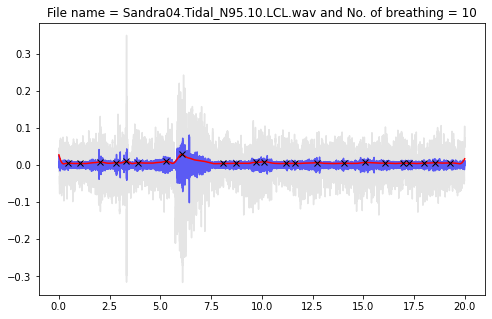

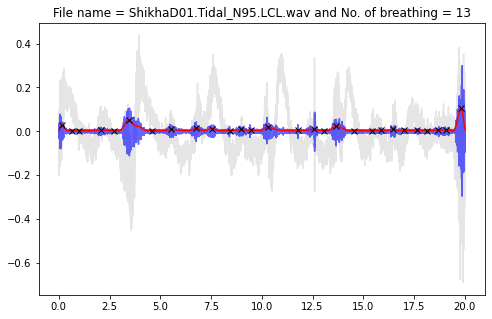

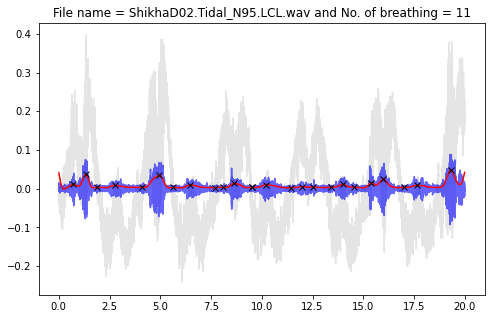

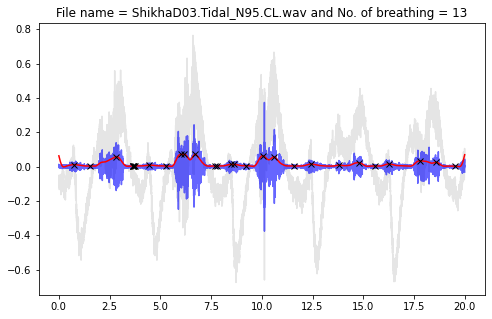

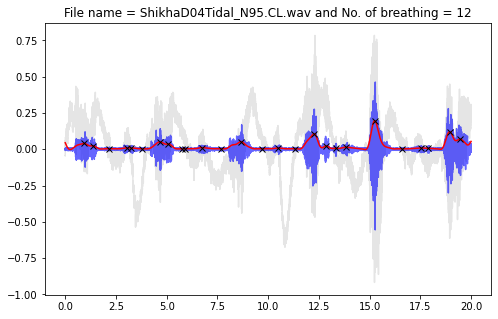

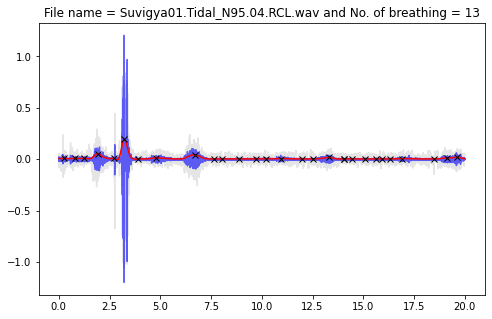

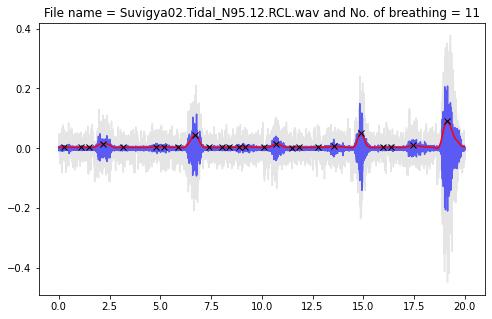

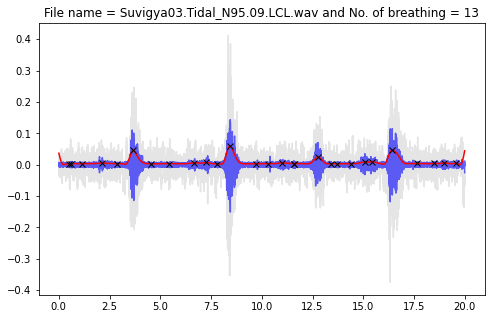

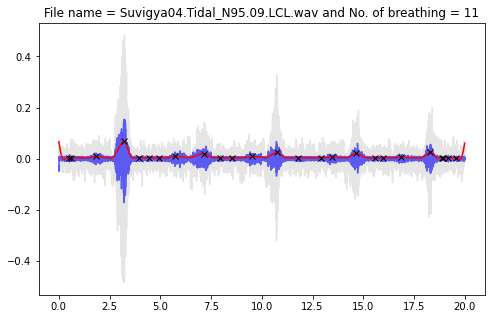

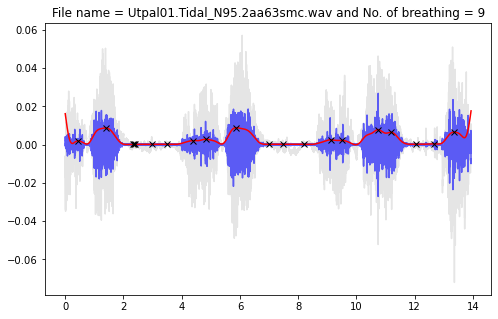

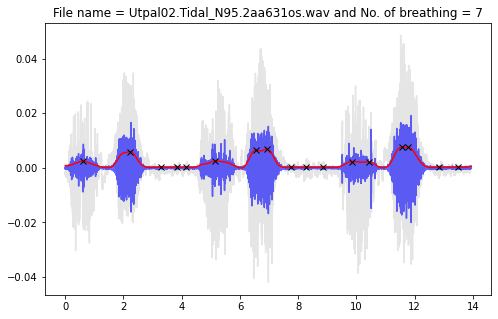

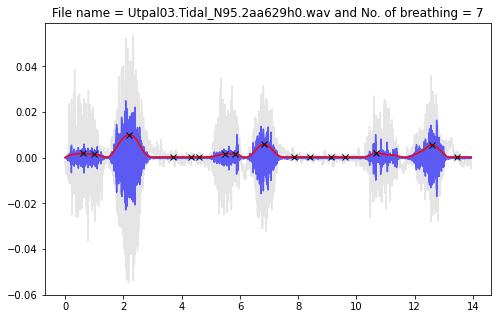

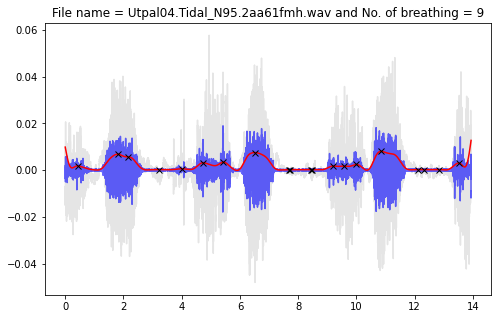

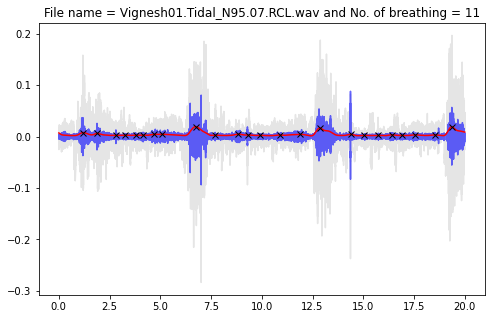

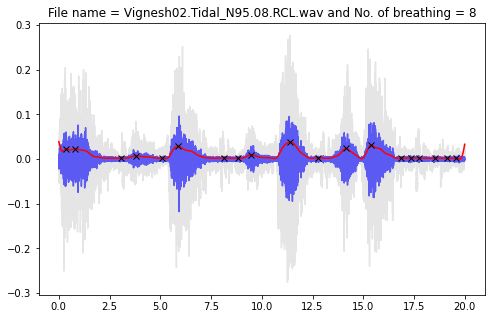

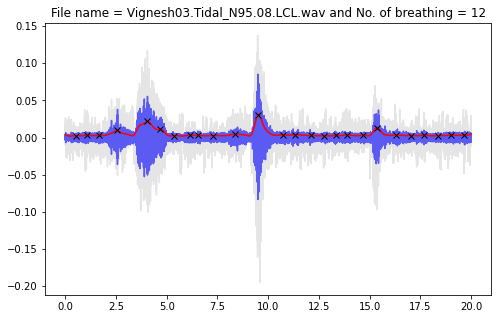

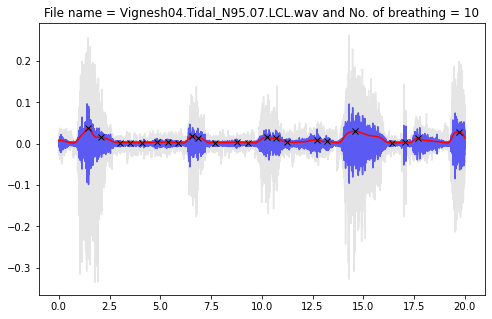

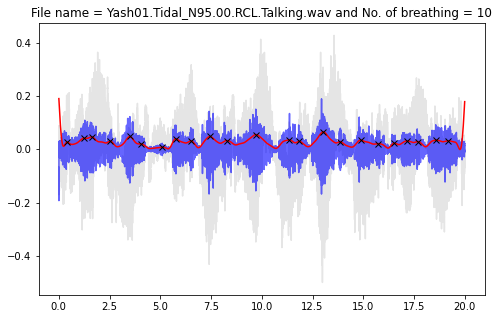

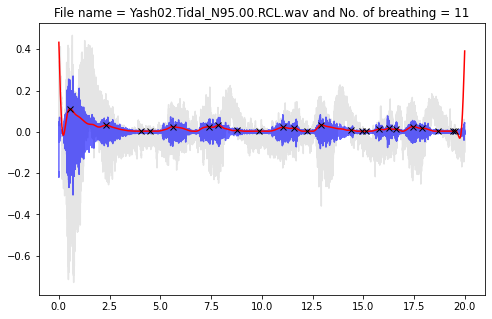

In [12]:
#now get the tidal breathing signal using empirical mode decomposition
#cutoff_low = 100 
#cutoff_high = 900
#order = 2
fs = 16000


for file in filenames:
    tidal, sr = librosa.load(mypath+file)
    tidal = tidal[0:fs*20]
    tidal_t = [s/fs for s in range(0,len(tidal))]

    #filtering using band passfilter
    #tidal_f = butter_bandpass_filter(tidal,cutoff_low,cutoff_high,fs,order)

    imfs = emd(tidal, nIMF = 6)
    #apply hilbert transform

    x_filt_hilbert = signal.hilbert(imfs[2])
    envelope_hat = np.abs(x_filt_hilbert)
    #filter the Hilbert envelope
    nyq_rate = fs /0.5
    width = 1.0/nyq_rate # 5 Hz filter transition width.
    ripple_db = 10.0 # stop band attenuation
    fL_hz = 10
    N, beta = signal.kaiserord(ripple_db, width)
    taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
    envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
    peaks,_ = find_peaks(envelope_hat_filt)

    '''
    ax[0].plot(tidal_t, imfs[0],'b', alpha=0.6)
    ax[0].plot(tidal_t, tidal,'k', alpha=0.1);
    ax[1].plot(tidal_t, imfs[1],'b', alpha=0.6)
    ax[1].plot(tidal_t, tidal,'k', alpha=0.1);
    ax[2].plot(tidal_t, imfs[2],'b', alpha=0.6)
    ax[2].plot(tidal_t, tidal,'k', alpha=0.1);
    ax[3].plot(tidal_t, imfs[3],'b', alpha=0.6)
    ax[3].plot(tidal_t, tidal,'k', alpha=0.1);
    ax[4].plot(tidal_t, imfs[4],'b', alpha=0.6)
    ax[4].plot(tidal_t, tidal,'k', alpha=0.1);
    ax[5].plot(tidal_t, imfs[5],'b', alpha=0.6)
    ax[5].plot(tidal_t, tidal,'k', alpha=0.1);
    '''
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    ax.plot(tidal_t, tidal,'k', alpha=0.1);
    ax.plot(tidal_t,imfs[2], 'b', alpha=0.6)
    ax.plot(tidal_t,envelope_hat_filt,'r');
    ax.plot([tidal_t[peak] for peak in peaks], [envelope_hat_filt[i] for i in peaks], "x", color='black')
    ax.set_title("File name = {} and No. of breathing = {}".format(file, (len(peaks)-2)//2))
    #print("Approximate breathing cylces = ",(len(peaks)-2)//2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


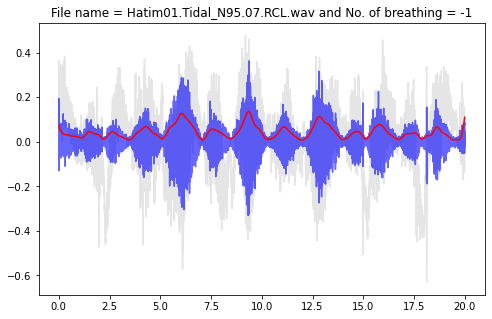

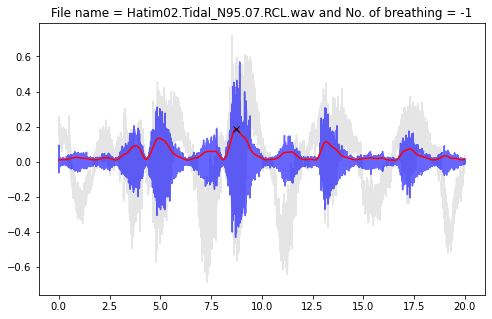

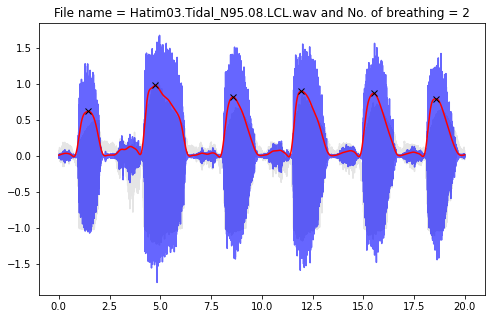

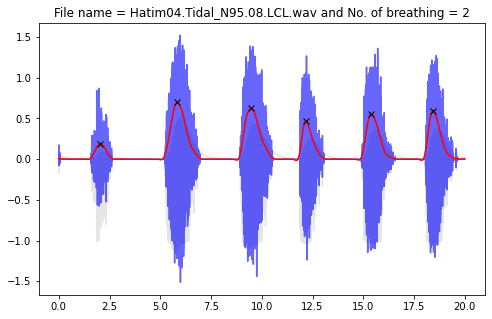

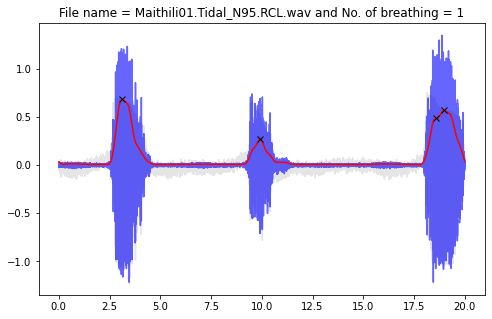

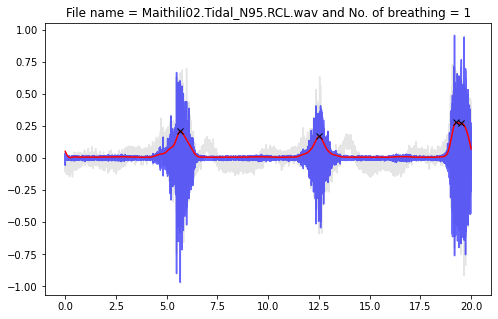

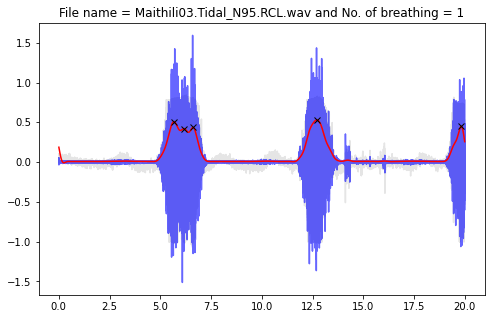

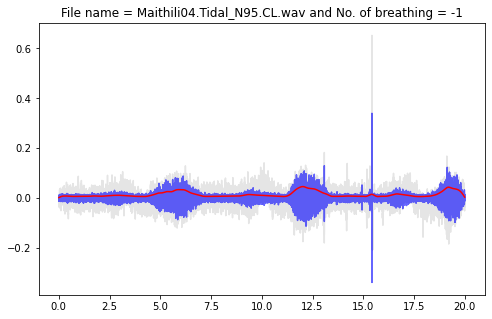

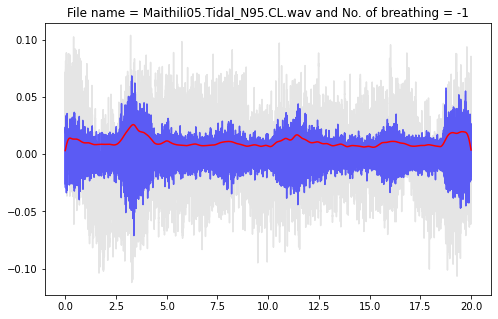

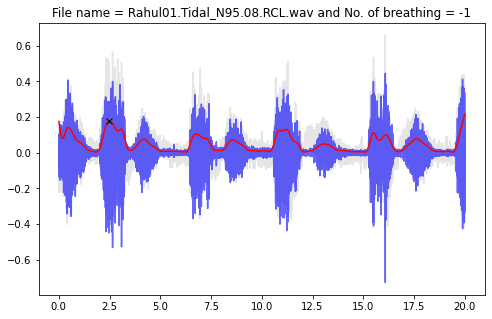

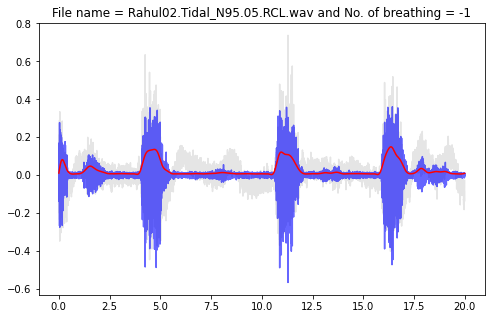

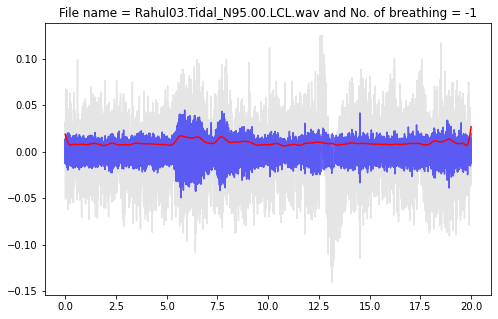

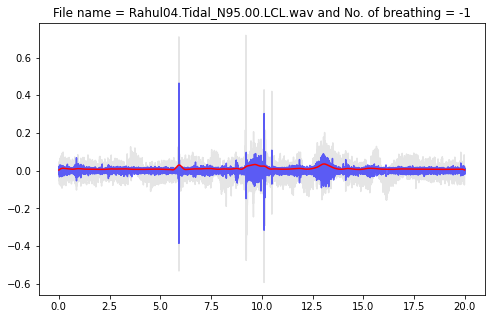

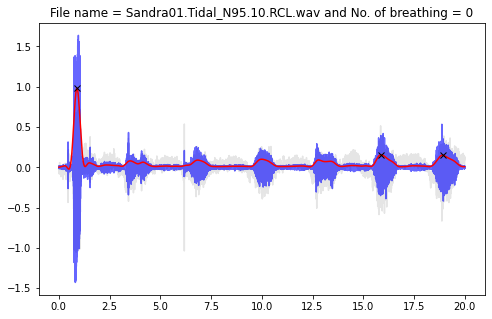

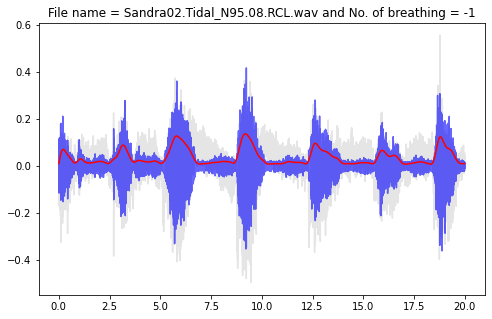

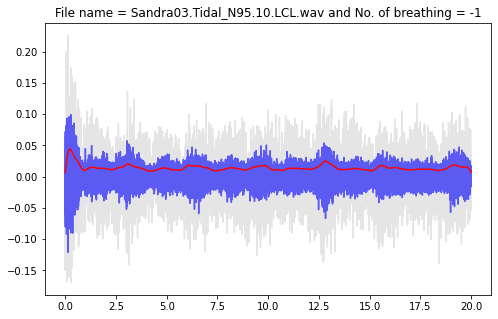

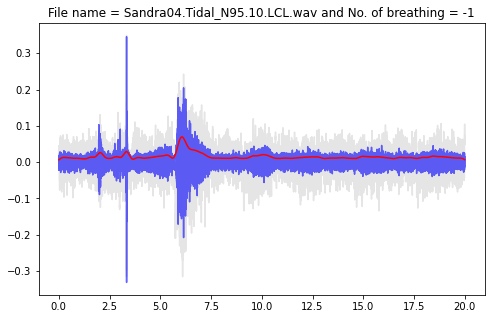

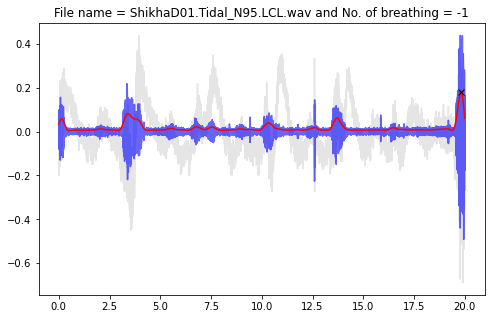

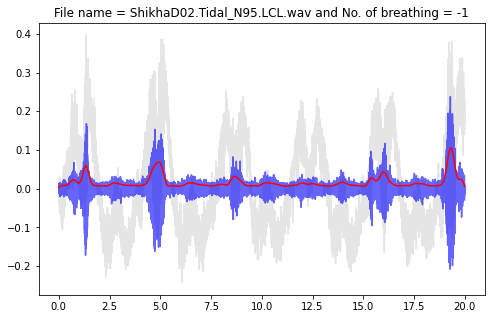

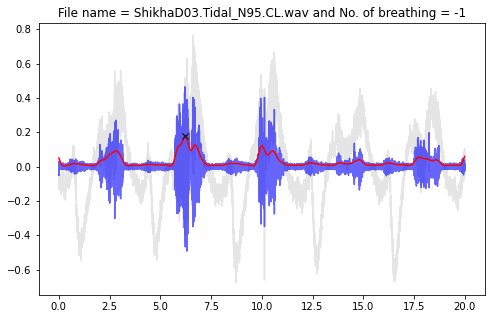

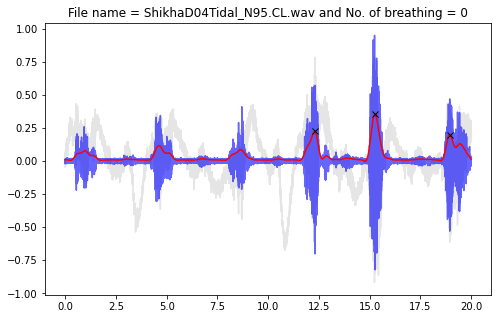

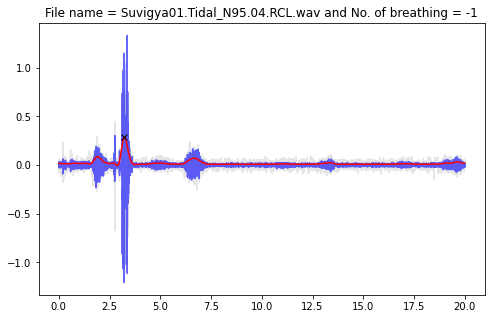

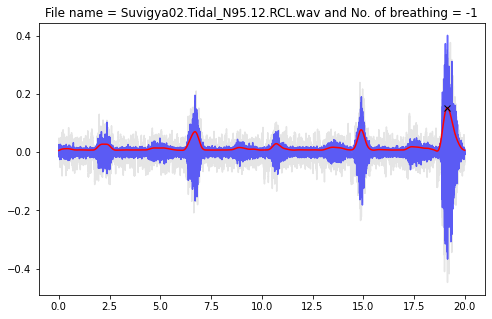

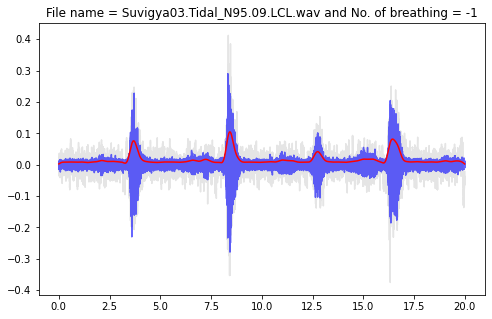

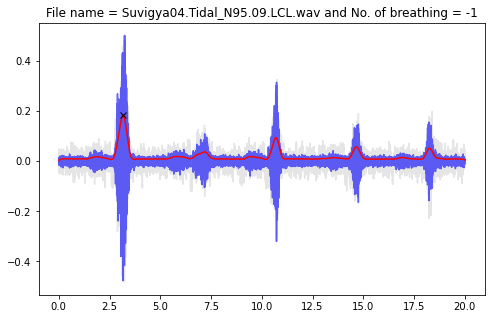

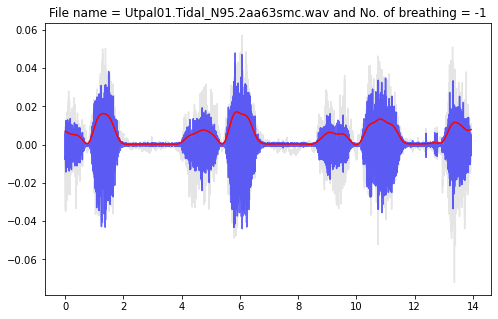

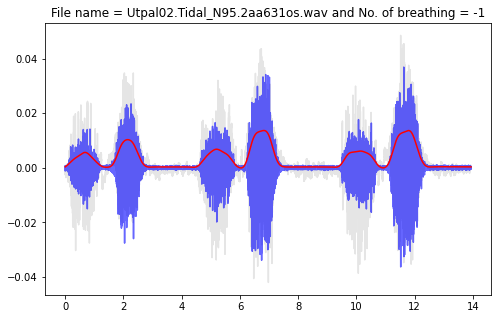

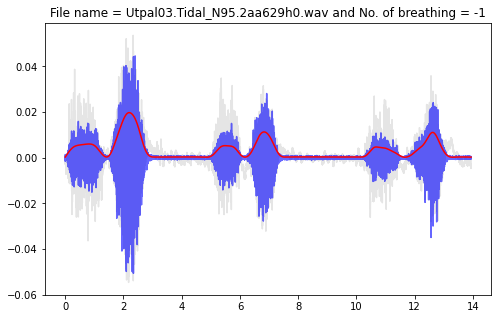

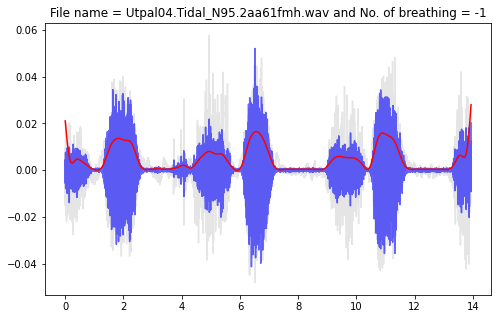

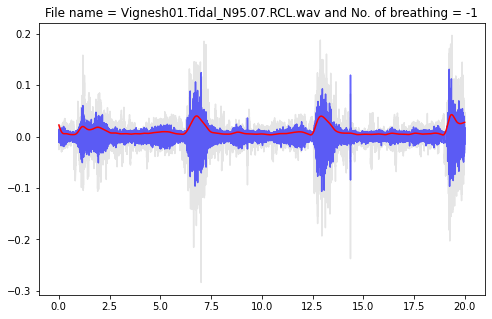

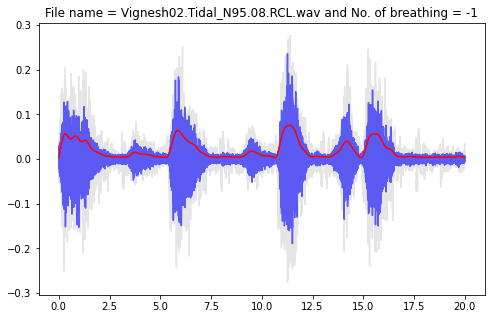

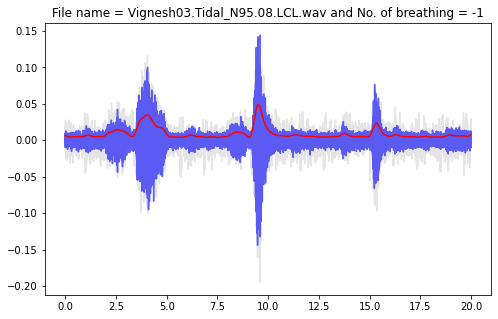

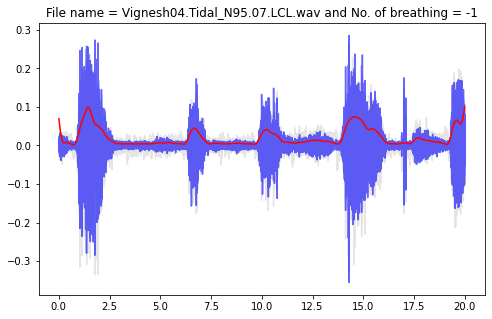

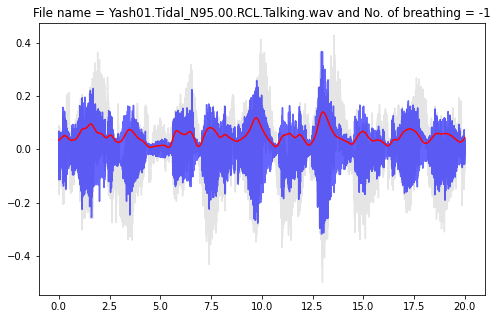

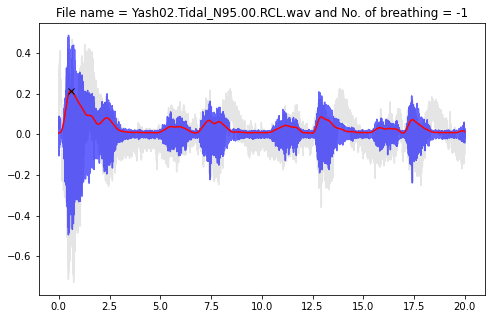

In [19]:
#now using hilbert transform
#https://www.atsjournals.org/doi/10.1164/ajrccm.162.3.9905104

cutoff_low = 100 
cutoff_high = 1200
order = 5
fs = 16000
for file in filenames:
    tidal, sr = librosa.load(mypath+file)
    tidal = tidal[0:fs*20]
    tidal_t = [s/fs for s in range(0,len(tidal))]

    #filtering using band passfilter
    tidal_f = butter_bandpass_filter(tidal,cutoff_low,cutoff_high,fs,order)

    #imfs = emd(tidal, nIMF = 6)
    #apply hilbert transform

    x_filt_hilbert = signal.hilbert(tidal_f)
    envelope_hat = np.abs(x_filt_hilbert)
    #filter the Hilbert envelope
    nyq_rate = fs /0.5
    width = 1.0/nyq_rate # 5 Hz filter transition width.
    ripple_db = 10.0 # stop band attenuation
    fL_hz = 10
    N, beta = signal.kaiserord(ripple_db, width)
    taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
    envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
    peaks,_ = find_peaks(envelope_hat_filt, height=0.15)

    '''
    ax[0].plot(tidal_t, imfs[0],'b', alpha=0.6)
    ax[0].plot(tidal_t, tidal,'k', alpha=0.1);
    ax[1].plot(tidal_t, imfs[1],'b', alpha=0.6)
    ax[1].plot(tidal_t, tidal,'k', alpha=0.1);
    ax[2].plot(tidal_t, imfs[2],'b', alpha=0.6)
    ax[2].plot(tidal_t, tidal,'k', alpha=0.1);
    ax[3].plot(tidal_t, imfs[3],'b', alpha=0.6)
    ax[3].plot(tidal_t, tidal,'k', alpha=0.1);
    ax[4].plot(tidal_t, imfs[4],'b', alpha=0.6)
    ax[4].plot(tidal_t, tidal,'k', alpha=0.1);
    ax[5].plot(tidal_t, imfs[5],'b', alpha=0.6)
    ax[5].plot(tidal_t, tidal,'k', alpha=0.1);
    '''
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    ax.plot(tidal_t, tidal,'k', alpha=0.1);
    ax.plot(tidal_t,tidal_f, 'b', alpha=0.6)
    ax.plot(tidal_t,envelope_hat_filt,'r');
    ax.plot([tidal_t[peak] for peak in peaks], [envelope_hat_filt[i] for i in peaks], "x", color='black')
    ax.set_title("File name = {} and No. of breathing = {}".format(file, (len(peaks)-2)//2))
    #print("Approximate breathing cylces = ",(len(peaks)-2)//2)

In [32]:
np.sqrt(df['X']+df['Y']+df['Z'])

0       3.697417
1       3.693530
2       3.698874
3       3.705341
4       3.710990
          ...   
1991    3.715987
1992    3.710022
1993    3.703402
1994    3.698550
1995    3.695474
Length: 1996, dtype: float64

(1860, 5)
Signal is 18.6 seconds long
Approximate breathing cylces =  2


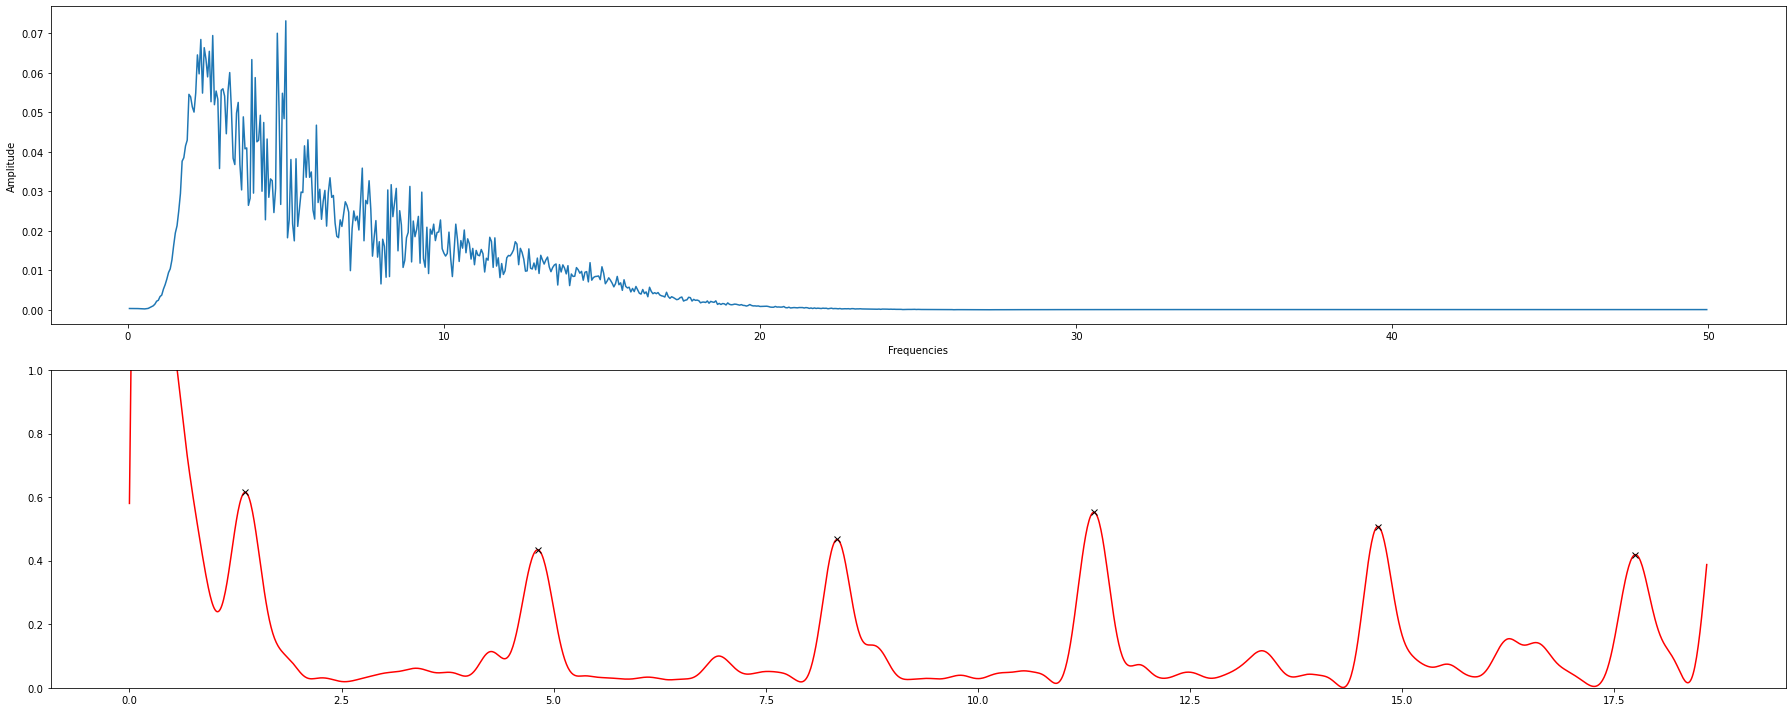

In [46]:
#df = pd.read_csv("SpiroMask-July2021/chestBandData/Rishiraj-2.csv", names=['X','Y','Z'])

df = pd.read_csv("SpiroMask-July2021/chestBandData/Rishiraj-3.csv")
df = df.drop(df.index[0:420])
df = df.reset_index()
print(df.shape)
sr=100
df['Time'] = [s/sr for s in range(0,df.shape[0])]

print("Signal is {} seconds long".format(df.shape[0]/sr))


fig, ax = plt.subplots(2,1,figsize=(25,10))
#peaks,_ = find_peaks(filtered)
#ax[0].plot(df['Z'], color='red');


#mag = np.sqrt(df['X']+df['Y']+df['Z'])

FS, HS = compute_fft(df['Y'], 100, scale_amplitudes=True)
#ax[1].plot(FS[1:], HS[1:]) #starts from 1 to avoid plotting DC component
#ax[1].set_xlabel('Frequencies')
#ax[1].set_ylabel('Amplitude');

cutoff_low = 2
cutoff_high = 15
order = 5

filteredHP = butter_bandpass_filter(df['Y'],cutoff_low,cutoff_high,sr,order)

FS, HS = compute_fft(filteredHP, 100, scale_amplitudes=True)
ax[0].plot(FS[1:], HS[1:]) #starts from 1 to avoid plotting DC component
ax[0].set_xlabel('Frequencies')
ax[0].set_ylabel('Amplitude');
#ax[3].plot(range(0, (len(df.Time)-100)), filteredHP[100:], color='red');

#apply hilbert transform
#fig, ax = plt.subplots(1,1, figsize=(8,5))
x_filt_hilbert = signal.hilbert(filteredHP)
envelope_hat = np.abs(x_filt_hilbert)
#filter the Hilbert envelope
nyq_rate = sr /0.5
width = 1.0/nyq_rate # 5 Hz filter transition width.
ripple_db = 10.0 # stop band attenuation
fL_hz = 10
N, beta = signal.kaiserord(ripple_db, width)
taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)

#find peaks
peaks,_ = find_peaks(envelope_hat_filt, height=0.35)

#ax.plot([s/fs for s in range(0,len(filteredHP))],envelope_hat_filt,'r')
ax[1].plot(df['Time'],envelope_hat_filt,'r')
ax[1].plot(df['Time'][peaks], [envelope_hat_filt[i] for i in peaks], "x", color='black')
ax[1].set_ylim([0,1])
print("Approximate breathing cylces = ",(len(peaks)-2)//2)
fig.tight_layout();


IMU Signal is 24.57 seconds long


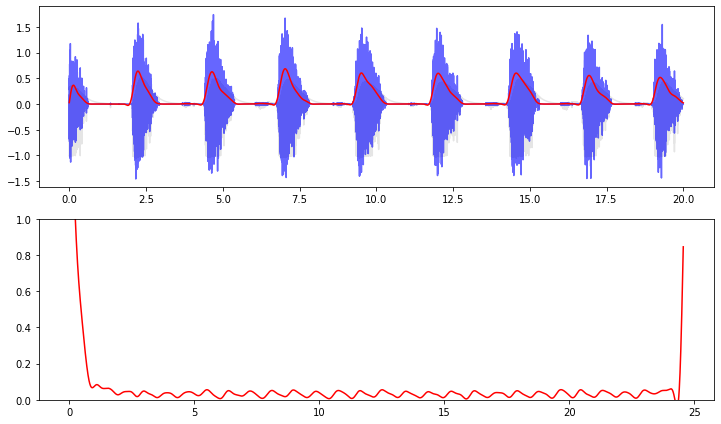

In [99]:
#one to one comparison
fig, ax = plt.subplots(2,1, figsize=(10,6))
timeInSeconds = 20

#read the audio data
tidal, fs = librosa.load('SpiroMask-July2021/SmartMaskData/Tidal/N95/Rishiraj.Tidal_C.10.RCL.2bqu23t7.wav')
tidal = tidal[0:fs*timeInSeconds]
tidal_t = [s/fs for s in range(0,len(tidal))]

#read the IMU data
df = pd.read_csv("SpiroMask-July2021/chestBandData/Rishiraj-5.csv")
#df = df.drop(df.index[0:420])
#df = df.reset_index()
sr=100
df['Time'] = [s/sr for s in range(0,df.shape[0])]
print("IMU Signal is {} seconds long".format(df.shape[0]/sr))


#filtering audio using band passfilter
cutoff_low = 100 
cutoff_high = 1200
order = 5
fs = 16000
tidal_f = butter_bandpass_filter(tidal,cutoff_low,cutoff_high,fs,order)
#apply hilbert transform
x_filt_hilbert = signal.hilbert(tidal_f)
envelope_hat = np.abs(x_filt_hilbert)
#filter the Hilbert envelope
nyq_rate = fs /0.5
width = 1.0/nyq_rate # 5 Hz filter transition width.
ripple_db = 10.0 # stop band attenuation
fL_hz = 10
N, beta = signal.kaiserord(ripple_db, width)
taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
peaks,_ = find_peaks(envelope_hat_filt, height=0.15)


#filtering the IMU data
FS, HS = compute_fft(df['Z'], sr, scale_amplitudes=True)
cutoff_low = 2
cutoff_high = 40
order = 5
filteredHP = butter_bandpass_filter(df['Z'],cutoff_low,cutoff_high,sr,order)
#filteredHP = df['Z']
x_filt_hilbert_imu = signal.hilbert(filteredHP)
envelope_hat_imu = np.abs(x_filt_hilbert_imu)
#filter the Hilbert envelope
nyq_rate = sr /0.5
width = 1.0/nyq_rate # 5 Hz filter transition width.
ripple_db = 10.0 # stop band attenuation
fL_hz = 10
N, beta = signal.kaiserord(ripple_db, width)
taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
envelope_hat_filt_imu = signal.filtfilt(taps, 1,envelope_hat_imu)
#find peaks
peaks_imu_,_ = find_peaks(envelope_hat_filt_imu, height=0.35)



ax[0].plot(tidal_t, tidal,'k', alpha=0.1);
ax[0].plot(tidal_t,tidal_f, 'b', alpha=0.6)
ax[0].plot(tidal_t,envelope_hat_filt,'r');
ax[1].plot(df['Time'],envelope_hat_filt_imu,'r')
ax[1].plot(df['Time'][peaks_imu_], [envelope_hat_filt_imu[i] for i in peaks_imu_], "x", color='black')
ax[1].set_ylim([0,1])
fig.tight_layout();


In [84]:
len(x / Fs)

8000